In [1]:
import jax
from jax import random, Array
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *

from gp import k, covariance_solve, flatten, PlotContext, cholesky_inv

key = random.PRNGKey(42)  # Create a random key                        

# Gaussian Process Regression with Derivatives (GPwDs)

In this notebook, we will explore **Gaussian Process Regression with Derivatives** (**GPwDs**) which can be applied to solve function approximation where we have the additional information of the derivatives of the function evaluated at inputs.

As a reminder, GP regression can be applied to solve *function approximation*, i.e., learning an unknown function $f: \mathbb{R}^D \rightarrow \mathbb{R}$ from a dataset $\mathcal{D} = \{(x_i, y_i) | x_i \in \mathbb{R}^D, y_i \in \mathbb{R} \}_i$ of function inputs and outputs.

## Function Approximation with Derivative Information

As a reminder, in function approximation, we attempt to learn an unknown function $f: \mathbb{R}^D \rightarrow \mathbb{R}$ from some hypothesis class $\mathcal{H}$ given a dataset $\mathcal{D} = \{(x_i, y_i) | x_i \in \mathbb{R}^D, y_i \in \mathbb{R} \}_{1 \leq i \leq N}$ of function input and output pairs $(x_i, y_i)$. In the setting with derivative information, we have a dataset $\mathcal{D} = \{(x_i, y_i, g_i) | x_i \in \mathbb{R}^D, y_i \in \mathbb{R}, g_i \in \mathbb{R}^D \}_i$ where $g_i = \nabla_{x_i} y_i$ is the gradient of $y_i$ with respect to $x_i$. We give an example of a dataset below.

In [2]:
def create_toy_deriv_dataset(f: Callable, key):
    N = 7; D = 1
    xs = jnp.linspace(-3, 3, N).reshape(-1, 1)

    # 1a. Sample random function
    def f(x: Array) -> float:
        return jnp.sin(x)

    # 1b. Associated gradient
    grad_f = jax.jacrev(f)

    # 2. Sample noise
    Sigma = jnp.diag(jnp.array([1e-4, 1e-2]))
    es = random.multivariate_normal(key, mean=jnp.zeros(1 + D), cov=Sigma, shape=(N,))

    # 3. Produce observations
    ys = jnp.array([f(x) + e[0] for x, e in zip(xs, es)])                   # outputs
    gs = jnp.array([grad_f(x).reshape(-1) + e[1] for x, e in zip(xs, es)])
    
    return xs, ys, gs, Sigma

f = lambda x: jnp.sin(x)
xs, ys, gs, Sigma = create_toy_deriv_dataset(f, key)
D = xs[0].shape[0]

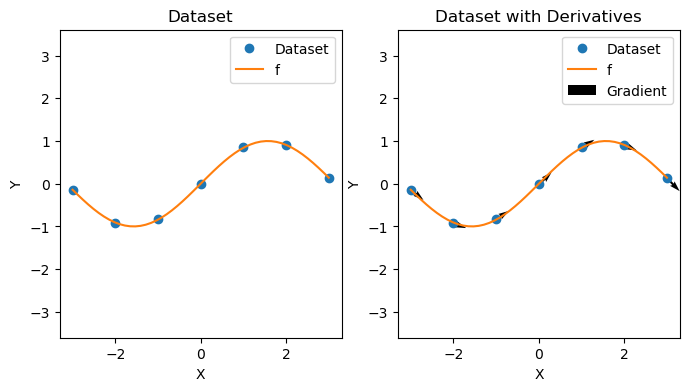

In [3]:
# Plot
def plot_deriv_dataset(xs: Array, ys: Array, gs: Array, f: Callable) -> None:
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1); plt.axis("equal") 
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(jnp.linspace(-3, 3), f(jnp.linspace(-3, 3)), label="f")
    plt.title("Dataset"); plt.xlabel("X"); plt.ylabel("Y"); plt.legend();

    plt.subplot(1, 2, 2); plt.axis("equal")
    origin = jnp.array([xs, ys])
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(jnp.linspace(-3, 3), f(jnp.linspace(-3, 3)), label="f")
    plt.quiver(*origin, jnp.ones(len(xs)), gs, label="Gradient")
    plt.title("Dataset with Derivatives"); plt.xlabel("X"); plt.ylabel("Y"); plt.legend();

plot_deriv_dataset(xs, ys, gs, f)

##  Gaussian Process with Derivatives (GPwD) Model

A GP has the property that if 

$$
f \sim GP(\mu, k)
$$ 

then

$$
\nabla f \sim GP(\nabla \mu, \nabla k \nabla^T) \,.
$$

We can use this observation to construct a Gaussian Process with Derivatives (GPwD) model. The notation $GP(\tilde{\mu}, \tilde{k})$ indicates a GPwD model with **mean** function $\tilde{\mu}: \mathbb{R}^D \rightarrow \mathbb{R}^{1 + D}$ and **kernel** function $k: \mathbb{R}^D \times \mathbb{R}^D \rightarrow \mathbb{R}^{(1 + D) \times (1 + D)}$.

Define a class of functions that packs together a function and its gradient as in

$$
\tilde{f}(x) = \begin{pmatrix}
f(x) \\
(\nabla f)(x)
\end{pmatrix} \,.
$$

Then

$$
\tilde{f} \sim GP(\tilde{\mu}, \tilde{k})
$$

whenever $f \sim GP(\mu, k)$ and $\nabla f \sim GP(\nabla \mu, \nabla k \nabla^T)$.

### Mean

The **mean** function $\tilde{\mu}: \mathbb{R}^D \rightarrow \mathbb{R}^{1 + D}$ is defined in terms of a base mean function $\mu: \mathbb{R}^D \rightarrow \mathbb{R}$ as

$$
\tilde{\mu}(x) = \begin{pmatrix}
\mu(x) \\
\nabla \mu(x)
\end{pmatrix} \,.
$$

As before, without loss of generality, we will use a mean function $\mu = 0$.

### Kernel

The **kernel** function $k: \mathbb{R}^D \times \mathbb{R}^D \rightarrow \mathbb{R}^{(1 + D) \times (1 + D)}$ is defined in terms of a based kernel function $k: \mathbb{R} \times \mathbb{R} \rightarrow \mathbb{R}$ as
\begin{align*}
\tilde{k}(x, x') & = \begin{pmatrix}
k(x, x') & \frac{\partial k}{\partial x'^T}(x, x') \\
\frac{\partial k}{\partial x}(x, x') & \frac{\partial^2 k}{\partial x\partial x'^T}(x, x')
\end{pmatrix} \\
& = \begin{pmatrix}
k(x, x') & k(x, x')\nabla_{x'}^T \\
\nabla_x k(x, x') & \nabla_x k(x, x')\nabla_{x'}^T
\end{pmatrix} \,.
\end{align*}

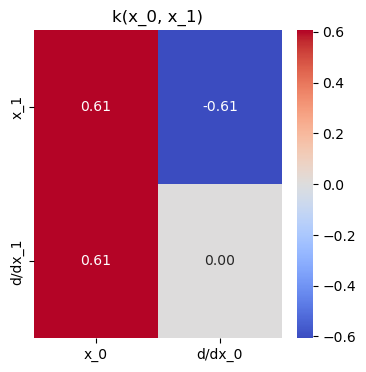

In [4]:
def kern_blk(k: Callable, x1: Array, x2: Array) -> Array:
    kern = jnp.array([k(x1, x2)])
    jac2 = jax.jacrev(k, argnums=1)(x1, x2)
    f_jac1 = jax.jacrev(k, argnums=0)
    jac1 = f_jac1(x1, x2).reshape(-1, 1)
    # Using forward-mode AD with reverse-mode AD to get the second derivative
    hes = jax.jacfwd(f_jac1, argnums=1)(x1, x2)

    # Put everything together
    top = jnp.concatenate([kern, jac2]).reshape(1, -1)
    bot = jnp.concatenate([jac1, hes], axis=1)
    K = jnp.concatenate([top, bot])
    return K

plt.figure(figsize=(4, 4))
sns.heatmap(
    kern_blk(k, xs[0], xs[1]), annot=True, cmap='coolwarm', fmt='.2f',
    xticklabels=["x_0", "d/dx_0"], yticklabels=["x_1", "d/dx_1"]
)
plt.title("k(x_0, x_1)");

### Covariance Matrix

Define a covariance matrix

$$
\tilde{K}_{xx'} = \begin{pmatrix}
\tilde{k}(x_1, x_1') & \dots & \tilde{k}(x_1, x_M') \\
\vdots & \ddots & \vdots \\
\tilde{k}(x_N, x_1') & \dots & \tilde{k}(x_N, x_M') \\
\end{pmatrix}
$$

which uses the GPwD kernel function $\tilde{k}$.

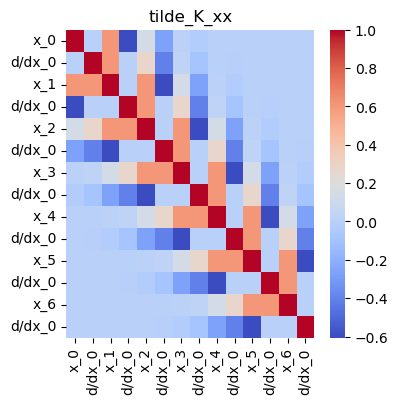

In [5]:
def mk_cov_blk(k: Callable, xs1: Array, xs2: Array) -> Array:
    return jnp.concatenate([
        jnp.concatenate([
            kern_blk(k, x1, x2) for x2 in xs2
        ], axis=1) for x1 in xs1
    ])

tilde_K_xx = mk_cov_blk(k, xs, xs)

plt.figure(figsize=(4, 4))
sns.heatmap(
    tilde_K_xx, annot=False, cmap='coolwarm', fmt='.2f',
    xticklabels=flatten([[f"x_{i}"] + [f"d/dx_{d}" for d in range(D)] for i in range(len(xs))]),
    yticklabels=flatten([[f"x_{i}"] + [f"d/dx_{d}" for d in range(D)] for i in range(len(xs))])
)
plt.title("tilde_K_xx");

### Gaussian Finite Dimensional Distributions

Since a GPwD is a multi-variate GP, we also have Gaussian finite dimensional distributions as in

$$
\begin{pmatrix}
\tilde{f}(x_1) \\
\vdots \\
\tilde{f}(x_N)
\end{pmatrix} \sim \mathcal{N}(\tilde{\mu}_x, \tilde{K}_{xx})
$$

for any finite set of inputs $\{x_1, \dots, x_N \}$. This relates the functions that a GPwD is defining via $\tilde{\mu}$ and $\tilde{k}$ with the dataset.

1. The variable $\tilde{\mu}_x$ is the vector of mean values

$$
\tilde{\mu}_x = \begin{pmatrix}
\tilde{\mu}(x_1) \\
\vdots \\
\tilde{\mu}(x_N)
\end{pmatrix} \,.
$$

2. The variable $\tilde{K}_{xx}$ is the covariance matrix from before.
3. For simplicity of notation, we may drop the subscripts related to the datasets so we may simply write $\tilde{\mu}$ for the vector of means and $\tilde{K}$ for the covariance matrix.

## GPwD Regression

We perform GPwD regression with the dataset $\mathcal{D} = \{(x_i, y_i, g_i) \}_{1 \leq i \leq N}$ by computing a **posterior predictive distribution**.

### Generative Process


We peform GPwD regression using the **generative process** below
\begin{align*}
\tilde{f} = \begin{pmatrix} 
f \\
\nabla f 
\end{pmatrix} & \sim GP(\tilde{\mu}, \tilde{k}) \tag{random function from $GP(\tilde{\mu}, \tilde{k})$} \\
\begin{pmatrix}
e_f \\
e_g \\
\end{pmatrix} & \sim \mathcal{N}\left(\begin{pmatrix}
0 \\
0
\end{pmatrix}, \begin{pmatrix}
    \Sigma_y & 0 \\
    0 & \Sigma_g
    \end{pmatrix} \right) \tag{noise} \\
\begin{pmatrix}
y_1 \\
g_1 \\
\vdots \\
y_N \\
g_N
\end{pmatrix} & = \begin{pmatrix}
f(x_1) + e_{f1} \\ 
\nabla f(x_1) + e_{g1} \\
\vdots \\
f(x_N) + e_{fN} \\ 
\nabla f(x_N) + e_{gN} \\
\end{pmatrix} \tag{model}
\end{align*}

### Posterior Predictive Distribution

1. Define a joint distribution on latent variables $\tilde{f} = (\tilde{f}(x_1) \, \dots \, \tilde{f}(x_N))^T$ (i.e., evaluated at $\{x_1, \dots, x_N\}$) and a test $\tilde{f}_* = \tilde{f}(x_*)$ (i.e., evaluated at $x_*$).

$$
p\begin{pmatrix}
\tilde{f} \\
\tilde{f}_*
\end{pmatrix} = \mathcal{N} \left( \begin{pmatrix}
0 \\
0 
\end{pmatrix}, \begin{pmatrix}
\tilde{K}_{\tilde{f}\tilde{f}} & \tilde{K}_{\tilde{f}*} \\
\tilde{K}_{*\tilde{f}} & \tilde{K}_{**}
\end{pmatrix} \right) \,.
$$

2. Then the posterior predictive distribution is

$$
p(\tilde{f}_* | \tilde{f}) = \mathcal{N}(\tilde{K}_{*\tilde{f}}(\tilde{K}_{\tilde{f}\tilde{f}} + \Sigma)^{-1}\tilde{f}, \tilde{K}_{**} - \tilde{K}_{*\tilde{f}}(\tilde{K}_{\tilde{f}\tilde{f}} + \Sigma)^{-1}\tilde{K}_{\tilde{f}*})
$$

following the vanilla GP posterior predictive prediction. The computational complexity of solving for a GPwD model with $N$ points in $D$ dimensions is $O(N^3D^3)$.

In [6]:
def fit_gpwd(k: Callable, xs: Array, hs: Array, Sigma) -> Array:
    tilde_K_xx_noise = jnp.concatenate([
        jnp.concatenate([
            kern_blk(k, x1, x2) + Sigma for x2 in xs
        ], axis=1) for x1 in xs
    ])
    return covariance_solve(tilde_K_xx_noise, hs), tilde_K_xx_noise

In [7]:
hs = jnp.concatenate([jnp.concatenate([y, g]) for y, g in zip(ys, gs)])
alpha_beta, tilde_K_xx_noise = fit_gpwd(k, xs, hs, Sigma)
alpha_beta

Array([  46.33245 ,   17.54342 ,   60.185867,   82.01008 ,  -50.76498 ,
         93.34061 , -118.73068 ,   -3.258196,  -38.893494,  -91.38596 ,
         56.328953,  -77.15878 ,   44.081795,  -18.35414 ], dtype=float32)

In [8]:
def gpwd_post_pred_mean(k: Callable, xs: Array, alpha_beta: Array, x_star: Array) -> Array:
    """Posterior predictive mean.
    """
    K_star_f = jnp.concatenate([kern_blk(k, x_star, x) for x in xs], axis=1)
    return K_star_f @ alpha_beta

def gpwd_post_pred_cov(k: Callable, xs: Array, tilde_K_xx_noise: Array, x_star: Array) -> Array:
    """Posterior predictive covariance.
    """
    K_star_star = kern_blk(k, x_star, x_star)
    K_star_f = jnp.concatenate([kern_blk(k, x_star, x) for x in xs], axis=1)
    return K_star_star - K_star_f @ cholesky_inv(tilde_K_xx_noise) @ K_star_f.transpose()

### Visualizing the Posterior Predictive

We visualize the GPwD model below. Observe that the shape of the uncertainty has been altered by the presence of gradient information compared to the vanilla GP case.

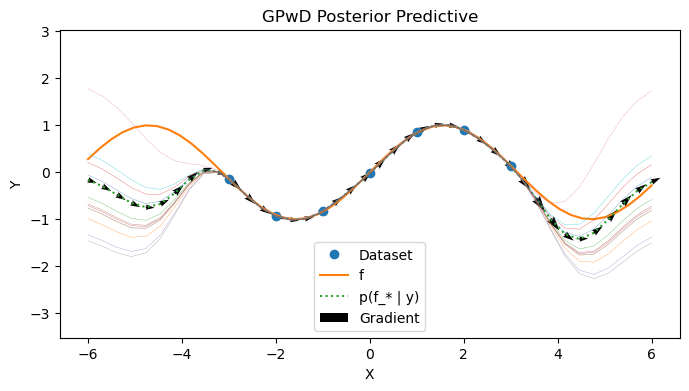

In [9]:
# Create posterior prediction
test_xs = jnp.linspace(-6, 6, 40)
post_tfs = [gpwd_post_pred_mean(k, xs, alpha_beta, jnp.array([x])) for x in test_xs]
post_mean = [h[0] for h in post_tfs]
post_cov = [gpwd_post_pred_cov(k, xs, tilde_K_xx_noise, jnp.array([x])) for x in test_xs]
post_ys = [random.normal(key, shape=(12,)) * jnp.sqrt(post_cov[i][0][0]) + post_mean[i] for i in range(len(test_xs))]
post_gs = [h[1:] for h in post_tfs]

with PlotContext(title="GPwD Posterior Predictive", xlabel="X", ylabel="Y") as ax:
    # Plot dataset
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(jnp.linspace(-6, 6), f(jnp.linspace(-6, 6)), label="f")

    # Plot predictions
    plt.plot(test_xs, post_mean, label="p(f_* | y)", linestyle="dotted")
    origin = jnp.array([test_xs, post_mean])
    plt.quiver(*origin, jnp.ones(len(test_xs)), post_gs, label="Gradient", width=0.01, scale=70)
    plt.plot(test_xs, post_ys, linewidth=0.2)

## References

1. [Gaussian Processes for Machine Learning: Chapter 2](https://gaussianprocess.org/gpml/chapters/RW2.pdf)

## Appendix

### Appendix: Kernel Derivation

We need to compute the covariances $Cov(f(x), \nabla f(x))$ and $Cov(\nabla f(x), \nabla_x f(x))$.

\begin{align*}
Cov(f(x), \nabla f(x)) & = \mathbb{E}[f(x) (\nabla f(x))^T] \tag{defn} \\
& = \mathbb{E}[f(x) (f(x))^T] \nabla_{x}^T \tag{linearity of $\nabla$ and $\mathbb{E}$} \\
& = \begin{pmatrix}
k(x_1, x_1) & \dots & k(x_1, x_N) \\
\vdots & \ddots & \vdots \\
k(x_N, x_1) & \dots & k(x_N, x_N) \\
\end{pmatrix} \nabla_{x}^T \tag{assumption} \\
& = \begin{pmatrix}
k(x_1, x_1)\nabla_{x_1}^T & \dots & k(x_1, x_N)\nabla_{x_N}^T \\
\vdots & \ddots & \vdots \\
k(x_N, x_1)\nabla_{x_1}^T & \dots & k(x_N, x_N)\nabla_{x_N}^T \\
\end{pmatrix} \tag{linearity} \\
\end{align*}

\begin{align*}
Cov(\nabla f(x), \nabla_x f(x)) & = \mathbb{E}[(\nabla f(x)) (\nabla f(x))^T] \tag{defn} \\
& = \nabla_x [\mathbb{E} (f(x) (f(x))^T] \nabla_{x}^T  \tag{linearity of $\nabla$ and $\mathbb{E}$} \\ \\
& = \nabla_x \begin{pmatrix}
k(x_1, x_1) & \dots & k(x_1, x_N) \\
\vdots & \ddots & \vdots \\
k(x_N, x_1) & \dots & k(x_N, x_N) \\
\end{pmatrix} \nabla_{x}^T \tag{assumption} \\
& = \begin{pmatrix}
\nabla_{x_1} k(x_1, x_1)\nabla_{x_1}^T & \dots & \nabla_{x_1} k(x_1, x_N)\nabla_{x_N}^T \\
\vdots & \ddots & \vdots \\
\nabla_{x_N} k(x_N, x_1)\nabla_{x_1}^T & \dots & \nabla_{x_N} k(x_N, x_N)\nabla_{x_N}^T \\
\end{pmatrix} \tag{linearity} \\
\end{align*}

### Appendix: Gradient of Prediction and Prediction of Gradient

The gradient of the prediction of the function value and the prediction of the gradient value of the function in a GPwD is the same.
\begin{align*}
\begin{pmatrix}
y_* \\
g_*
\end{pmatrix} & = \tilde{K}_{x*}\alpha \\
& = \begin{pmatrix}
k(x_*, x_1) & k(x_*, x_1)\nabla_{x_1}^T & \dots & k(x_*, x_n) & k(x_*, x_n)\nabla_{x_n}^T\\
\nabla_{x_*} k(x_*, x_1) & \nabla_{x_*} k(x_*, x_1)\nabla_{x_1}^T & \dots & \nabla_{x_*} k(x_*, x_1) & \nabla_{x_*} k(x_*, x_1)\nabla_{x_1}^T
\end{pmatrix} \begin{pmatrix}
\alpha_1^f \\
\alpha_1^g \\
\vdots \\
\alpha_N^f \\
\alpha_N^g
\end{pmatrix} \\
& = \begin{pmatrix}
\sum_{i=1}^N k(x_*, x_i)\alpha_i^f + k(x_*, x_1)\nabla_{x_1}^T \alpha_i^g \\
\sum_{i=1}^N \nabla_{x_*} k(x_*, x_i) \alpha_i^f + \nabla_{x_*} k(x_*, x_1)\nabla_{x_1}^T \alpha_i^g \\
\end{pmatrix} \,.
\end{align*}

Thus
\begin{align*}
\nabla_{x_* }y_*(x_*) & = \nabla_{x_* } \sum_{i=1}^N k(x_*, x_i)\alpha_i^f + k(x_*, x_1)\nabla_{x_1}^T \alpha_i^g \tag{definition} \\
& = \sum_{i=1}^N \nabla_{x_* }k(x_*, x_i)\alpha_i^f + \nabla_{x_* }k(x_*, x_1)\nabla_{x_1}^T \alpha_i^g \tag{linearity of $\nabla$} \\
& = g_*(x_*) \tag{definition} \\
\end{align*}